# Proyek Prediksi Customer Churn

> Dokumentasi end-to-end untuk memantau dan menurunkan churn pelanggan telekomunikasi melalui analisis data, pemodelan prediktif, dan interpretasi bisnis.

> **Daftar Isi Cepat**
- 1️⃣ Pendahuluan
- 2️⃣ Persiapan Lingkungan & Integrasi Data
- 3️⃣ Eksplorasi Data (EDA)
- 4️⃣ Rekayasa Fitur & Preprocessing
- 5️⃣ Pelatihan Model Baseline
- 6️⃣ Optimalisasi Model
- 7️⃣ Interpretasi & Insight
- 8️⃣ Kesimpulan & Rekomendasi

## 1. Pendahuluan
Notebook ini mendokumentasikan perjalanan analitik mulai dari pemahaman data hingga interpretasi model agar setiap keputusan teknis memiliki alasan bisnis yang jelas.

### 1.1 Latar Belakang Bisnis
Churn pelanggan menggambarkan situasi ketika pelanggan berhenti menggunakan layanan perusahaan telekomunikasi. Dampaknya langsung terasa pada pendapatan karena biaya akuisisi pelanggan baru biasanya jauh lebih mahal dibanding mempertahankan pelanggan eksisting. Dengan menganalisis perilaku pemakaian layanan dan pola pembayaran, perusahaan dapat mengidentifikasi pelanggan berisiko sejak dini dan menyiapkan strategi retensi yang lebih presisi.

### 1.2 Tujuan Analisis
- Membangun pipeline prediktif yang memetakan pelanggan ke kelas **churn** atau **non-churn** tanpa kebocoran informasi pada tahap preprocessing.
- Menggali faktor pendorong churn lewat visualisasi, pentingnya fitur, dan interpretasi SHAP agar tim bisnis memahami pemicu utama.
- Menyusun rekomendasi taktis yang dapat segera dijalankan untuk menurunkan churn di segmen prioritas.

### 1.3 Ringkasan Dataset
Data berasal dari enam tabel operasional yang saling terhubung melalui `customer_id` dan setelah digabung menghasilkan lebih dari 7.000 pelanggan dengan 40+ kolom. Struktur utama:
- **`Customer_Info`** — demografi pelanggan (gender, usia, status pernikahan, jumlah tanggungan).
- **`Location_Data`** — rincian wilayah (negara bagian, kota, kode pos, koordinat).
- **`Online_Services`** — langganan layanan digital (internet, keamanan, backup, streaming, dukungan teknis).
- **`Payment_Info`** — tipe kontrak, metode pembayaran, total tagihan, penjumlahan pendapatan.
- **`Service_Options`** — opsi tambahan termasuk `tenure`, paket data, dan aktivitas referral.
- **`Status_Analysis`** — status pelanggan terbaru dan label churn (`churn_value`).

> 📌 **Catatan Integritas Data**: Diagram ER internal memastikan relasi satu-ke-satu antar tabel sehingga proses penggabungan aman dilakukan sebelum tahap analisis lanjutan.

## 2. Persiapan Lingkungan & Integrasi Data
Langkah kedua mempersiapkan seluruh pustaka analitik serta menggabungkan keenam tabel sumber menjadi satu data mart analitis yang siap dieksplorasi.

In [29]:
# Pustaka manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from IPython.display import display

# Pustaka machine learning dan pemrosesan fitur
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
 )
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin, clone

# Pustaka sampling untuk menangani imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Pustaka interpretabilitas model (opsional, akan memberikan peringatan jika belum terpasang)
try:
    import shap
except ImportError:
    shap = None
    print("Peringatan: paket shap belum terpasang. Jalankan !pip install shap untuk visualisasi SHAP.")

try:
    from lime.lime_tabular import LimeTabularExplainer
except ImportError:
    LimeTabularExplainer = None
    print("Peringatan: paket lime belum terpasang. Jalankan !pip install lime jika ingin menggunakan LIME.")

try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None
    print("Peringatan: paket xgboost belum terpasang. Jalankan !pip install xgboost untuk menggunakan model XGBoost.")

# Konfigurasi visualisasi
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

### 2.1 Muat & Gabungkan Dataset
Kita memuat enam tabel sumber, menyeragamkan nama kolom, menghapus atribut redundan, lalu menggabungkannya berdasarkan `customer_id`. Output kode akan menampilkan jumlah pelanggan unik serta dimensi tabel hasil gabungan.

In [30]:
# Menetapkan direktori data dan memuat seluruh tabel
data_dir = Path("data")
customer_info = pd.read_csv(data_dir / "Customer_Info.csv")
location_data = pd.read_csv(data_dir / "Location_Data.csv")
online_services = pd.read_csv(data_dir / "Online_Services.csv")
payment_info = pd.read_csv(data_dir / "Payment_Info.csv")
service_options = pd.read_csv(data_dir / "Service_Options.csv")
status_analysis = pd.read_csv(data_dir / "Status_Analysis.csv")

# Membersihkan nama kolom agar seragam (huruf kecil dan tanpa spasi)
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_", regex=False)
        .str.replace("__", "_", regex=False)
    )
    return df

customer_info = clean_columns(customer_info)
location_data = clean_columns(location_data)
online_services = clean_columns(online_services)
payment_info = clean_columns(payment_info)
service_options = clean_columns(service_options)
status_analysis = clean_columns(status_analysis)

# Menghapus kolom duplikat sebelum penggabungan (sudah tersedia di tabel lain)
service_options = service_options.drop(columns=["internet_service", "phone_service"], errors="ignore")

# Menggabungkan seluruh tabel pada kunci customer_id
data_raw = (
    customer_info
    .merge(location_data, on="customer_id", how="inner")
    .merge(online_services, on="customer_id", how="inner")
    .merge(payment_info, on="customer_id", how="inner")
    .merge(service_options, on="customer_id", how="inner")
    .merge(status_analysis, on="customer_id", how="inner")
)

data = data_raw.copy()

print(f"Jumlah pelanggan unik: {data_raw['customer_id'].nunique()}")
print(f"Dimensi data gabungan: {data_raw.shape}")

Jumlah pelanggan unik: 7043
Dimensi data gabungan: (7043, 51)


### 2.2 Audit Struktur Awal
Meninjau pratinjau baris dan komposisi tipe data membantu kita memahami bentuk data hasil gabungan sekaligus mengidentifikasi kolom kategorikal/numerik sejak dini.

In [31]:
# Meninjau struktur awal data gabungan
data = data_raw.copy()

print("Pratinjau lima baris pertama:")
display(data.head())

print("\nRingkasan tipe data (jumlah kolom per tipe):")
display(data.dtypes.value_counts())

Pratinjau lima baris pertama:


,customer_id,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married,country,...,referred_a_friend,number_of_referrals,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason
0,0002-ORFBO,Female,37,No,No,Yes,No,0,Yes,United States,...,Yes,2,3,2205,Stayed,65,No,0,Not Applicable,NaN
1,0003-MKNFE,Male,46,No,No,No,No,0,No,United States,...,No,0,5,5414,Stayed,66,No,0,Not Applicable,NaN
2,0004-TLHLJ,Male,50,No,No,No,No,0,No,United States,...,No,0,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,No,Yes,Yes,No,0,Yes,United States,...,Yes,1,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,No,Yes,Yes,No,0,Yes,United States,...,Yes,3,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability



Ringkasan tipe data (jumlah kolom per tipe):


object     31
int64      12
float64     8
Name: count, dtype: int64

#### 2.3 Profil Nilai Hilang & Duplikasi
Kode berikut menampilkan ringkasan `info()`, statistik numerik, sepuluh kolom dengan nilai hilang tertinggi, serta jumlah duplikasi berbasis `customer_id`. Informasi ini menentukan kolom mana yang perlu dihapus atau diimputasi.

In [32]:
# Ringkasan statistik dan nilai hilang awal
print("\nInformasi detail kolom:")
data.info()

print("\nRingkasan statistik numerik:")
display(data.describe().T)

print("\nJumlah nilai hilang per kolom (Top 10):")
missing_report = (
    data
    .isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda df: df["missing_count"] / len(data))
    .sort_values("missing_pct", ascending=False)
    .head(10)
 )
display(missing_report)

duplicate_count = data.duplicated(subset="customer_id").sum()
print(f"\nJumlah duplikasi berdasarkan customer_id: {duplicate_count}")


Informasi detail kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 51 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   under_30                           7043 non-null   object 
 4   senior_citizen                     7043 non-null   object 
 5   partner                            7043 non-null   object 
 6   dependents                         7043 non-null   object 
 7   number_of_dependents               7043 non-null   int64  
 8   married                            7043 non-null   object 
 9   country                            7043 non-null   object 
 10  state                              7043 non-null   object 
 11  city                           

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
number_of_dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
zip_code,7043.0,93486.071134,1856.768045,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
total_population,7043.0,22139.814568,21152.174407,11.000000,2344.000000,17554.000000,36125.000000,105285.000000
latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
monthly_charges,7043.0,64.761692,30.090047,18.250000,35.500000,70.350000,89.850000,118.750000
avg_monthly_long_distance_charges,7043.0,22.958954,15.448113,0.000000,9.210000,22.890000,36.395000,49.990000
total_charges,7043.0,2280.381264,2266.220462,18.800000,400.150000,1394.550000,3786.600000,8684.800000
total_refunds,7043.0,1.962182,7.902614,0.000000,0.000000,0.000000,0.000000,49.790000



Jumlah nilai hilang per kolom (Top 10):


,missing_count,missing_pct
churn_reason,5174,0.734630
offer,3877,0.550476
internet_type,1526,0.216669
under_30,0,0.000000
senior_citizen,0,0.000000
monthly_charges,0,0.000000
avg_monthly_long_distance_charges,0,0.000000
total_charges,0,0.000000
total_refunds,0,0.000000
total_extra_data_charges,0,0.000000



Jumlah duplikasi berdasarkan customer_id: 0


### 2.4 Pembersihan Awal & Seleksi Kolom
Tahap ini menghapus kolom target-derivative dari `Status_Analysis`, menyingkirkan atribut dengan nilai hilang >40%, serta memastikan tidak ada duplikasi `customer_id`. Sisa nilai hilang akan diatasi nanti oleh pipeline imputasi.

In [33]:

# Pembersihan awal data dan penghapusan kolom target-derivative
data_clean = data.copy()

# Kolom dari Status_Analysis yang tidak boleh dijadikan fitur
status_columns = [
    "satisfaction_score",
    "cltv",
    "customer_status",
    "churn_score",
    "churn_label",
    "churn_category",
    "churn_reason"
 ]
available_status_drop = [col for col in status_columns if col in data_clean.columns]
if available_status_drop:
    data_clean = data_clean.drop(columns=available_status_drop)
    print(f"Kolom status dihapus dari fitur: {available_status_drop}")

# Menetapkan ambang batas missing value
missing_threshold = 0.4
missing_info = data_clean.isna().sum().to_frame(name="missing_count")
missing_info["missing_pct"] = missing_info["missing_count"] / len(data_clean)

high_missing_columns = missing_info[missing_info["missing_pct"] > missing_threshold].index.tolist()
if high_missing_columns:
    data_clean = data_clean.drop(columns=high_missing_columns)
    print(f"Kolom dengan missing > {missing_threshold*100:.0f}% dihapus: {high_missing_columns}")
else:
    print("Tidak ada kolom yang perlu dihapus karena missing tinggi.")

duplicate_mask = data_clean.duplicated(subset="customer_id")
duplicate_count = duplicate_mask.sum()
if duplicate_count > 0:
    data_clean = data_clean[~duplicate_mask]
    print(f"Duplikasi berdasarkan customer_id dihapus: {duplicate_count} baris.")
else:
    print("Tidak ditemukan duplikasi berdasarkan customer_id.")

remaining_missing = data_clean.isna().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if not remaining_missing.empty:
    remaining_summary = (
        remaining_missing.to_frame(name="missing_count")
        .assign(missing_pct=lambda df: df["missing_count"] / len(data_clean))
        .sort_values("missing_pct", ascending=False)
    )
    display(remaining_summary.head(10))
    print("Kolom di atas akan diimputasi menggunakan median (numerik) atau modus (kategorikal) melalui pipeline dan hanya fitting pada data latih.")
else:
    print("Tidak ada nilai hilang tersisa setelah pembersihan awal.")

print(f"\nDimensi data setelah pembersihan awal: {data_clean.shape}")

Kolom status dihapus dari fitur: ['satisfaction_score', 'cltv', 'customer_status', 'churn_score', 'churn_label', 'churn_category', 'churn_reason']
Kolom dengan missing > 40% dihapus: ['offer']
Tidak ditemukan duplikasi berdasarkan customer_id.


,missing_count,missing_pct
internet_type,1526,0.216669


Kolom di atas akan diimputasi menggunakan median (numerik) atau modus (kategorikal) melalui pipeline dan hanya fitting pada data latih.

Dimensi data setelah pembersihan awal: (7043, 43)


> ✅ **Ringkasan Pembersihan**
Kolom turunan churn seperti skor dan alasan dihapus agar hanya `churn_value` yang menjadi label. Kolom dengan nilai hilang di atas 40% juga dieliminasi, sementara sisanya akan diimputasi melalui pipeline berbasis data latih. Setelah pembersihan, dataset bebas duplikasi `customer_id` dengan dimensi baru ditampilkan pada output kode.

## 3. Eksplorasi Data (EDA)
Bagian ini menyoroti pola distribusi churn, demografi, layanan, serta perilaku pembayaran untuk menemukan sinyal awal sebelum pemodelan. Setiap visualisasi dipasangkan dengan insight naratif agar temuan mudah dioperasionalkan.

### 3.1 Distribusi Churn & Demografi
Langkah pertama menganalisis proporsi churn dan perbandingan sederhana terhadap gender serta kontrak untuk memahami profil pelanggan yang paling rentan.

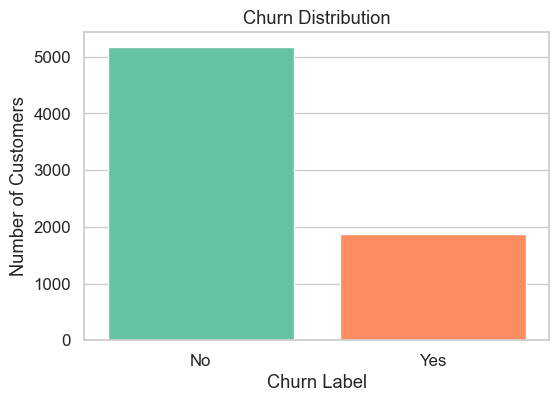

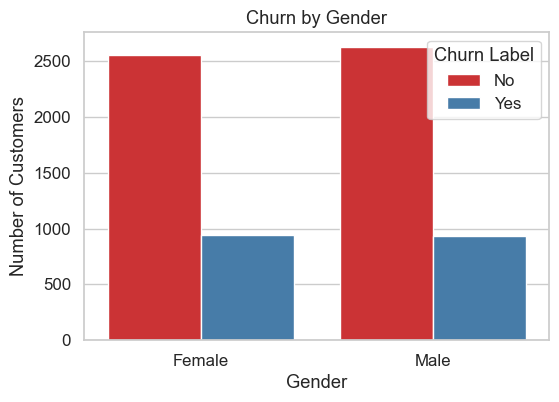

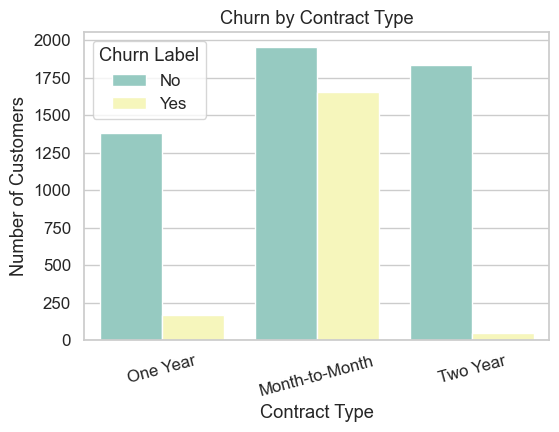

In [6]:
# Visualisasi distribusi churn dan demografi pelanggan
eda_base = data_clean.assign(churn_flag=lambda df: df["churn_value"].map({0: "No", 1: "Yes"}))
plt.figure(figsize=(6,4))
ax = sns.countplot(data=eda_base, x="churn_flag")
bar_colors = sns.color_palette("Set2", n_colors=len(ax.patches))
for patch, color in zip(ax.patches, bar_colors):
    patch.set_facecolor(color)
plt.title("Churn Distribution")
plt.xlabel("Churn Label")
plt.ylabel("Number of Customers")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=eda_base, x="gender", hue="churn_flag", palette="Set1")
plt.title("Churn by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.legend(title="Churn Label")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=eda_base, x="contract", hue="churn_flag", palette="Set3")
plt.title("Churn by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Number of Customers")
plt.xticks(rotation=15)
plt.legend(title="Churn Label")
plt.show()

**Insight Highlight:** Proporsi churn mencapai ~27% dan didominasi pelanggan dengan kontrak bulanan. Distribusi gender relatif seimbang sehingga strategi retensi lebih efektif bila difokuskan pada tipe kontrak daripada segmen gender.

### 3.2 Intensitas Tagihan & Tenure
Visualisasi berikut memeriksa distribusi tenure, biaya bulanan, dan revenue per month dengan pembeda churn untuk mendeteksi outlier finansial sejak awal.

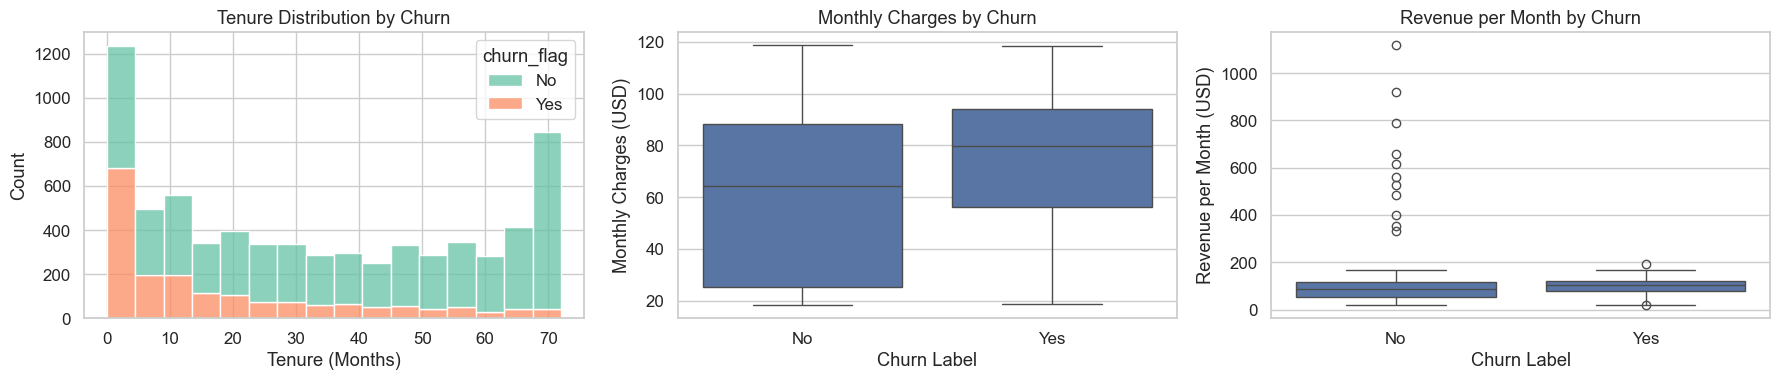

In [7]:
# Visualisasi distribusi fitur numerik kunci
eda_df = data_clean.assign(
    churn_flag=lambda df: df["churn_value"].map({0: "No", 1: "Yes"}),
    tenure_years=lambda df: df["tenure"] / 12,
    revenue_per_month=lambda df: df["total_revenue"] / np.where(df["tenure"] == 0, 1, df["tenure"])
)
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(data=eda_df, x="tenure", hue="churn_flag", multiple="stack", palette="Set2", ax=axes[0])
axes[0].set_title("Tenure Distribution by Churn")
axes[0].set_xlabel("Tenure (Months)")
axes[0].set_ylabel("Count")

sns.boxplot(data=eda_df, x="churn_flag", y="monthly_charges", ax=axes[1])
box_colors_monthly = sns.color_palette("Set3", n_colors=len(axes[1].artists))
for artist, color in zip(axes[1].artists, box_colors_monthly):
    artist.set_facecolor(color)
axes[1].set_title("Monthly Charges by Churn")
axes[1].set_xlabel("Churn Label")
axes[1].set_ylabel("Monthly Charges (USD)")

sns.boxplot(data=eda_df, x="churn_flag", y="revenue_per_month", ax=axes[2])
box_colors_revenue = sns.color_palette("Set1", n_colors=len(axes[2].artists))
for artist, color in zip(axes[2].artists, box_colors_revenue):
    artist.set_facecolor(color)
axes[2].set_title("Revenue per Month by Churn")
axes[2].set_xlabel("Churn Label")
axes[2].set_ylabel("Revenue per Month (USD)")

plt.tight_layout()
plt.show()

### 3.3 Profil Skewness Fitur Numerik
Kita menghitung skewness untuk seluruh fitur numerik (kecuali target) guna mengidentifikasi distribusi miring ekstrem yang berpotensi memengaruhi pemodelan atau membutuhkan transformasi khusus.

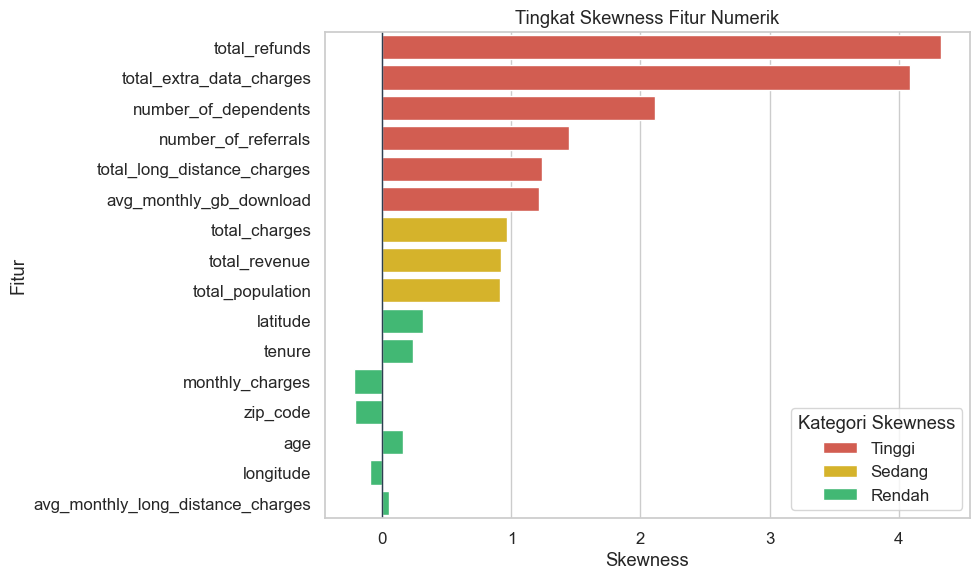

,feature,skewness,abs_skew,skew_level
0,total_refunds,4.328517,4.328517,Tinggi
1,total_extra_data_charges,4.091209,4.091209,Tinggi
2,number_of_dependents,2.109932,2.109932,Tinggi
3,number_of_referrals,1.446060,1.446060,Tinggi
4,total_long_distance_charges,1.238282,1.238282,Tinggi
5,avg_monthly_gb_download,1.216584,1.216584,Tinggi
6,total_charges,0.963791,0.963791,Sedang
7,total_revenue,0.919410,0.919410,Sedang
8,total_population,0.912884,0.912884,Sedang
9,latitude,0.314804,0.314804,Rendah


In [8]:
# Analisis skewness untuk fitur numerik
numeric_features = data_clean.select_dtypes(include=np.number).drop(columns=["churn_value"], errors="ignore")
skew_series = numeric_features.skew().sort_values(key=lambda s: s.abs(), ascending=False)
skew_df = (
    skew_series
    .reset_index()
    .rename(columns={"index": "feature", 0: "skewness"})
    .assign(abs_skew=lambda df: df["skewness"].abs())
 )
skew_df["skew_level"] = skew_df["abs_skew"].apply(
    lambda val: "Tinggi" if val >= 1 else ("Sedang" if val >= 0.5 else "Rendah")
 )

plt.figure(figsize=(10, 6))
palette = {"Tinggi": "#e74c3c", "Sedang": "#f1c40f", "Rendah": "#2ecc71"}
sns.barplot(data=skew_df, x="skewness", y="feature", hue="skew_level", dodge=False, palette=palette)
plt.axvline(0, color="#2c3e50", linewidth=1)
plt.title("Tingkat Skewness Fitur Numerik")
plt.xlabel("Skewness")
plt.ylabel("Fitur")
plt.legend(title="Kategori Skewness")
plt.tight_layout()
plt.show()

skew_df.head(10)

#### 3.3.1 Distribusi Fitur Paling Miring
Histogram dengan KDE untuk empat fitur paling skew akan membantu memutuskan apakah transformasi tambahan diperlukan sebelum modeling.

C:\Users\Rhendy Saragih\AppData\Local\Temp\ipykernel_15968\1620471722.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Churn")
C:\Users\Rhendy Saragih\AppData\Local\Temp\ipykernel_15968\1620471722.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Churn")
C:\Users\Rhendy Saragih\AppData\Local\Temp\ipykernel_15968\1620471722.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Churn")
C:\Users\Rhendy Saragih\AppData\Local\Temp\ipykernel_15968\1620471722.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with

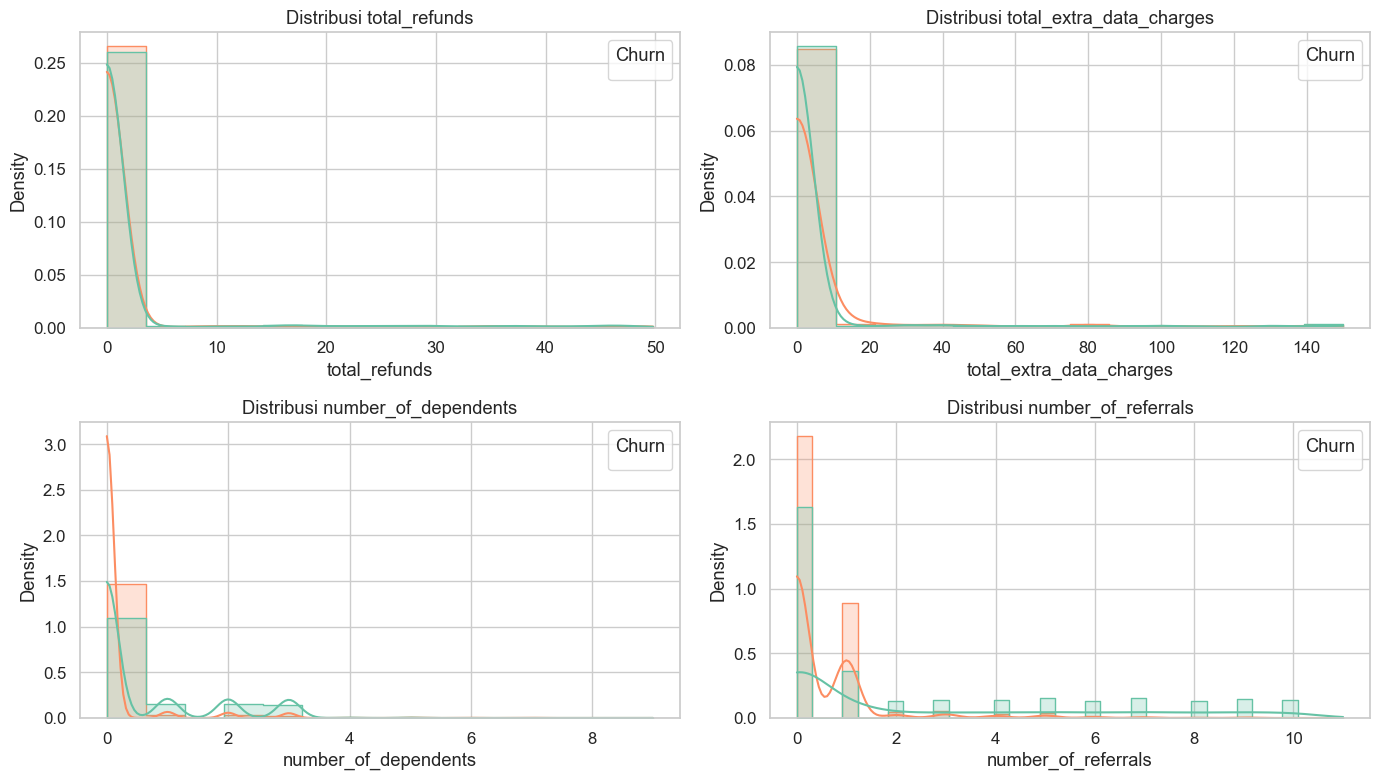

In [9]:
# Distribusi detail untuk fitur dengan skewness tinggi
top_skew_features = skew_df.head(4)["feature"].tolist()
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
for ax, feature in zip(axes, top_skew_features):
    sns.histplot(data=data_clean, x=feature, hue=data_clean["churn_value"].map({0: "No", 1: "Yes"}),
                 kde=True, element="step", stat="density", common_norm=False, ax=ax, palette="Set2")
    ax.set_title(f"Distribusi {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend(title="Churn")
plt.tight_layout()
plt.show()

**Insight Skewness:** Fitur finansial seperti `total_refunds` dan `total_extra_data_charges` menunjukkan skewness tinggi (>4) karena mayoritas pelanggan nyaris tidak melakukan refund atau membeli data ekstra, namun sebagian kecil pelanggan menghasilkan ekor kanan yang panjang. Distribusi `number_of_dependents` dan `number_of_referrals` juga sangat miring, menandakan nilai nol mendominasi. Sebaliknya, fitur seperti `monthly_charges` dan `tenure` memiliki skewness rendah sehingga asumsi distribusi mendekati simetris masih valid. Hal ini menyarankan perlakuan khusus (misalnya transformasi log atau winsorizing) bila model sensitif terhadap outlier, terutama saat mengevaluasi pengaruh biaya tambahan terhadap churn.

**Insight Numerik:** Pelanggan dengan tenure singkat dan tagihan bulanan tinggi tampil sebagai outlier di kelas churn. Rasio revenue per month terhadap tenure menegaskan perlunya program bundling bernilai lebih untuk segmen early-tenure dengan biaya tinggi.

### 3.4 Preferensi Layanan & Pembayaran
Visualisasi berikut menggali keterkaitan churn dengan jenis layanan internet serta metode pembayaran untuk menemukan pola kebiasaan pelanggan.

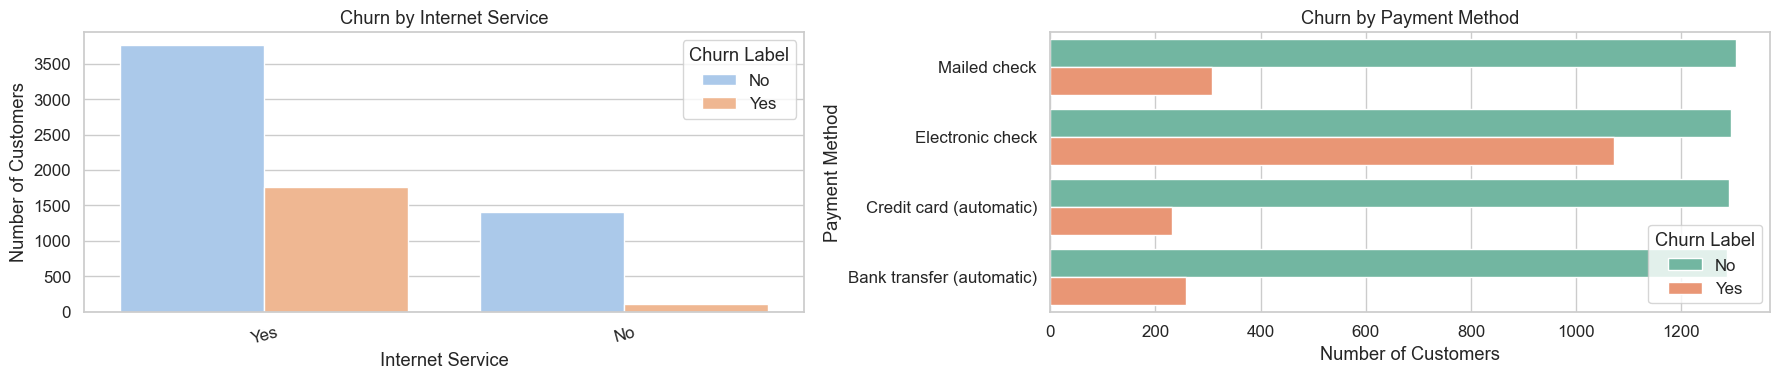

In [10]:
# Visualisasi tambahan untuk layanan dan pembayaran
eda_services = data_clean.assign(churn_flag=lambda df: df["churn_value"].map({0: "No", 1: "Yes"}))
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.countplot(data=eda_services, x="internet_service", hue="churn_flag", palette="pastel", ax=axes[0])
axes[0].set_title("Churn by Internet Service")
axes[0].set_xlabel("Internet Service")
axes[0].set_ylabel("Number of Customers")
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend(title="Churn Label")

top_payment = (
    eda_services
    .groupby(["payment_method", "churn_flag"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
 )
sns.barplot(data=top_payment, x="count", y="payment_method", hue="churn_flag", palette="Set2", ax=axes[1])
axes[1].set_title("Churn by Payment Method")
axes[1].set_xlabel("Number of Customers")
axes[1].set_ylabel("Payment Method")
axes[1].legend(title="Churn Label")

plt.tight_layout()
plt.show()

### 3.5 Tenure & Segmentasi Kontrak
Heatmap di bawah memperlihatkan churn rate berdasarkan bucket tenure dan jenis kontrak untuk mengungkap momentum terbaik dalam menawarkan upgrade kontrak.

C:\Users\Rhendy Saragih\AppData\Local\Temp\ipykernel_15968\3504355950.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["tenure_bucket", "contract"])


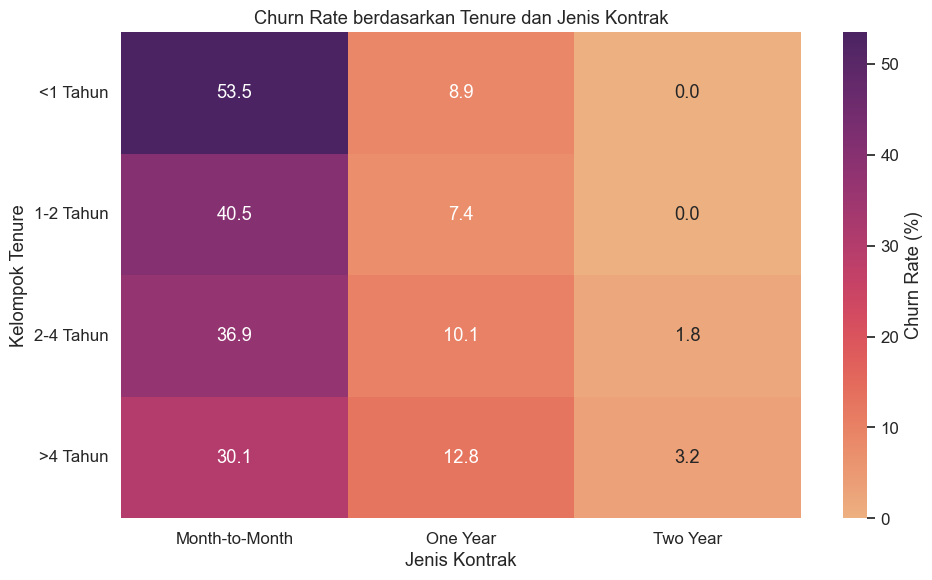

In [11]:
# Segmentasi churn berdasarkan tenure bucket dan jenis kontrak
tenure_bins = [-np.inf, 12, 24, 48, np.inf]
tenure_labels = ["<1 Tahun", "1-2 Tahun", "2-4 Tahun", ">4 Tahun"]
eda_tenure = data_clean.copy()
eda_tenure["tenure_bucket"] = pd.cut(eda_tenure["tenure"], bins=tenure_bins, labels=tenure_labels)
tenure_contract = (
    eda_tenure
    .groupby(["tenure_bucket", "contract"])
    ["churn_value"]
    .mean()
    .reset_index()
)
tenure_contract["churn_pct"] = tenure_contract["churn_value"] * 100

plt.figure(figsize=(10,6))
sns.heatmap(
    tenure_contract.pivot(index="tenure_bucket", columns="contract", values="churn_pct"),
    annot=True, fmt=".1f", cmap="flare", cbar_kws={"label": "Churn Rate (%)"}
 )
plt.title("Churn Rate berdasarkan Tenure dan Jenis Kontrak")
plt.xlabel("Jenis Kontrak")
plt.ylabel("Kelompok Tenure")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.6 Paperless Billing & Metode Pembayaran
Diagram batang berikut menunjukkan kombinasi metode pembayaran dan status paperless yang paling rentan mengalami churn.

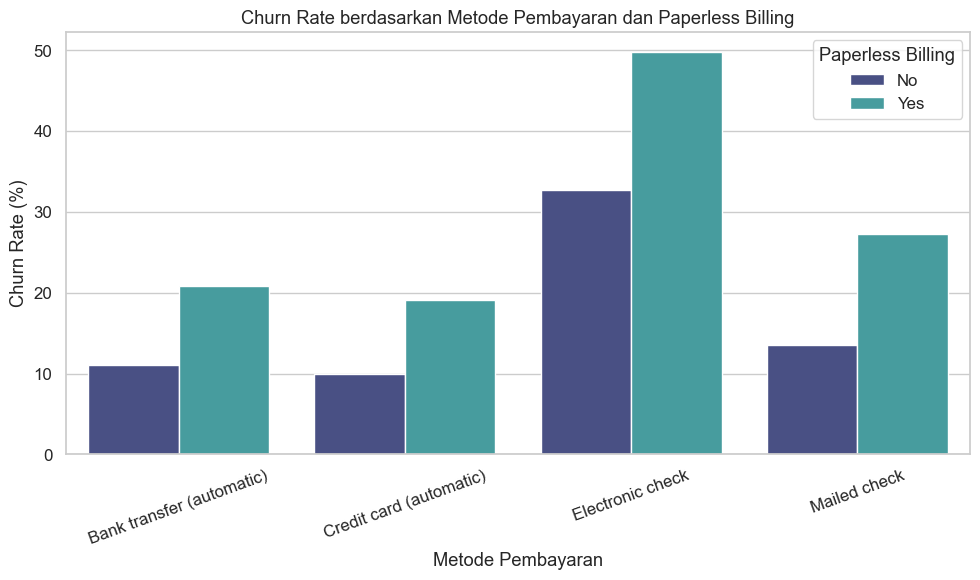

In [12]:
# Analisis churn berdasarkan metode pembayaran dan penggunaan paperless billing
payment_paperless = (
    data_clean
    .groupby(["payment_method", "paperless_billing"])
    ["churn_value"]
    .mean()
    .reset_index()
)
payment_paperless["churn_pct"] = payment_paperless["churn_value"] * 100

plt.figure(figsize=(10,6))
sns.barplot(
    data=payment_paperless,
    x="payment_method",
    y="churn_pct",
    hue="paperless_billing",
    palette="mako"
 )
plt.title("Churn Rate berdasarkan Metode Pembayaran dan Paperless Billing")
plt.xlabel("Metode Pembayaran")
plt.ylabel("Churn Rate (%)")
plt.xticks(rotation=20)
plt.legend(title="Paperless Billing")
plt.tight_layout()
plt.show()

### 3.7 Aktivasi Layanan Tambahan
Grafik garis memperlihatkan bagaimana penambahan layanan add-on berkorelasi dengan penurunan churn rate, memberikan gambaran efektivitas strategi bundling.

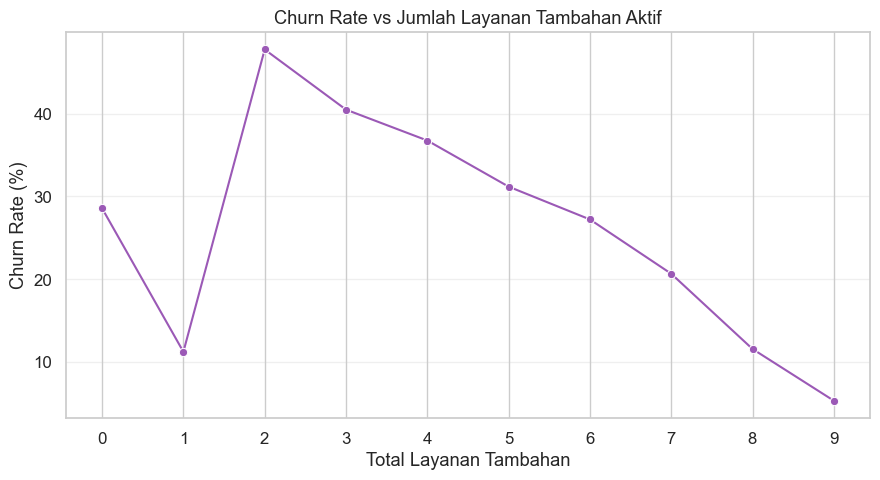

In [13]:
# Churn rate berdasarkan jumlah layanan tambahan yang diaktifkan
service_cols = [
    "phone_service", "online_security", "online_backup", "device_protection",
    "premium_tech_support", "streaming_tv", "streaming_movies", "streaming_music",
    "unlimited_data"
 ]
service_cols = [col for col in service_cols if col in data_clean.columns]
addon_df = data_clean.copy()
if service_cols:
    addon_df["total_addon_services"] = addon_df[service_cols].apply(lambda row: row.eq("Yes").sum(), axis=1)
    addon_summary = (
        addon_df
        .groupby("total_addon_services")
        ["churn_value"]
        .mean()
        .reset_index()
)
    addon_summary["churn_pct"] = addon_summary["churn_value"] * 100

    plt.figure(figsize=(9,5))
    sns.lineplot(data=addon_summary, x="total_addon_services", y="churn_pct", marker="o", color="#9b59b6")
    plt.title("Churn Rate vs Jumlah Layanan Tambahan Aktif")
    plt.xlabel("Total Layanan Tambahan")
    plt.ylabel("Churn Rate (%)")
    plt.xticks(addon_summary["total_addon_services"])
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Kolom layanan tambahan tidak ditemukan pada dataset setelah pembersihan.")

**Insight Layanan Tambahan:** Probabilitas churn turun drastis setelah pelanggan mengaktifkan empat atau lebih layanan tambahan. Hal ini membuka peluang untuk menawarkan bundling digital/premium tech support kepada pelanggan dengan sedikit add-on.

**Insight Pembayaran:** Kombinasi metode `Electronic check` dan tagihan non-paperless memiliki churn rate tertinggi. Edukasi pembayaran otomatis dan insentif auto-debit penting untuk menurunkan risiko di segmen ini.

**Insight Tenure & Kontrak:** Pelanggan dengan tenure <2 tahun yang masih berkontrak bulanan mengalami churn rate tertinggi. Intervensi ideal adalah menawarkan upgrade ke kontrak tahunan saat tenure 6–18 bulan.

**Insight Layanan & Internet:** Segmen pengguna internet fiber dengan metode pembayaran elektronik menanggung porsi churn besar. Strategi retensi bisa berupa edukasi value-added service fiber plus opsi pembayaran otomatis yang lebih stabil.

### 3.8 Analisis Korelasi Numerik
Heatmap berikut memetakan keterkaitan linear antar fitur numerik untuk mendeteksi multikolinieritas dan kandidat fitur yang selaras dengan churn.

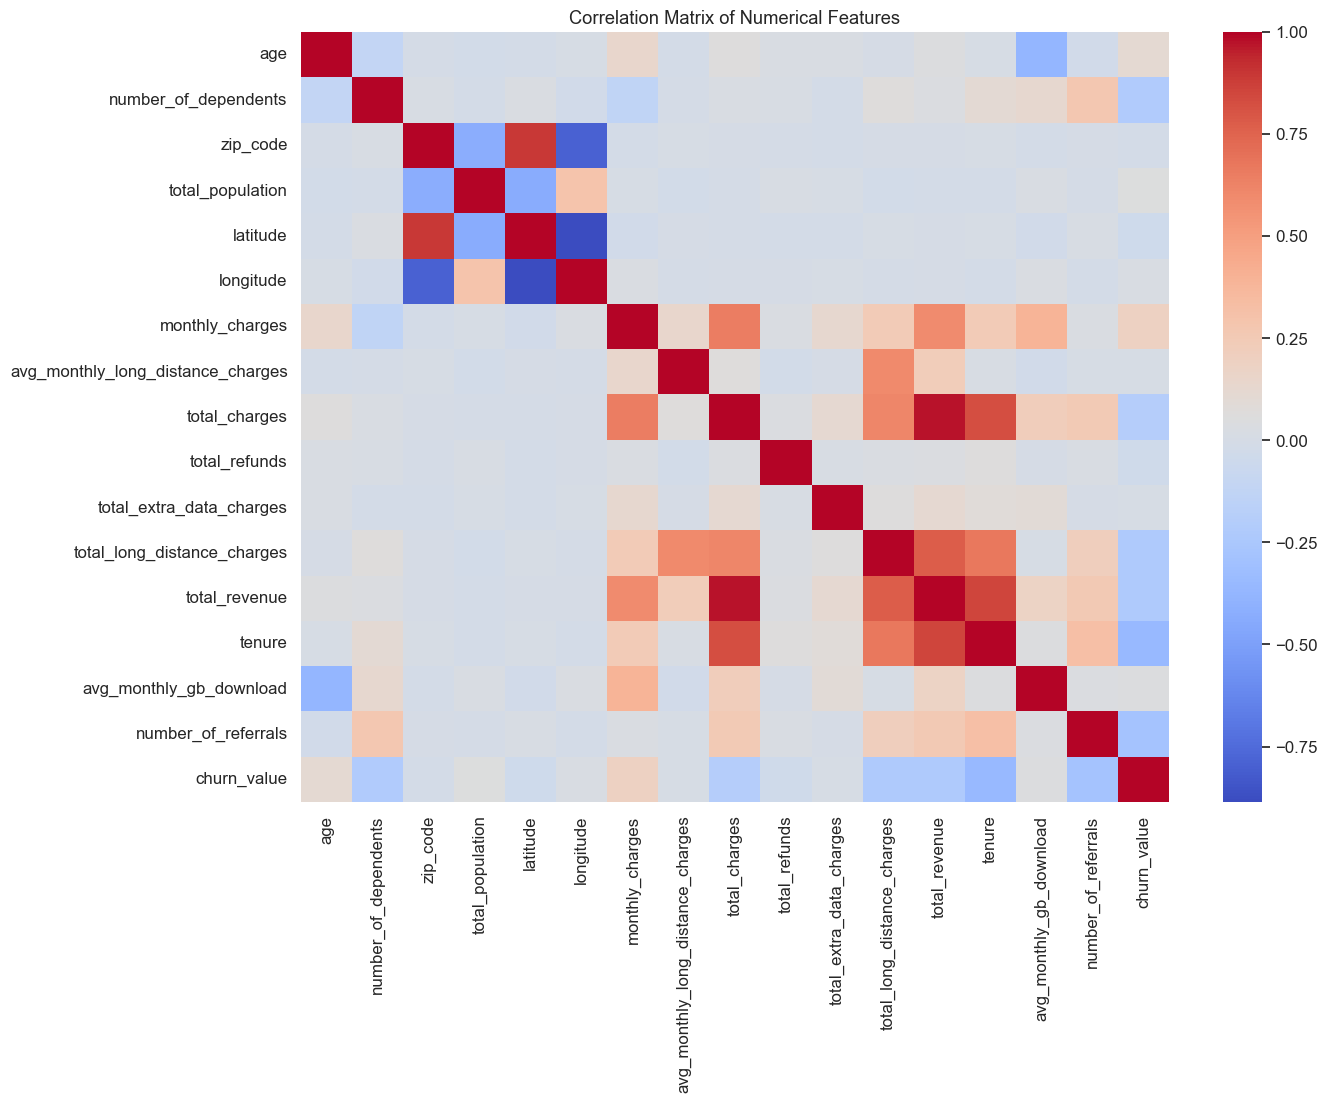

In [14]:
# Menghitung korelasi antar fitur numerik
numeric_cols_for_corr = data_clean.select_dtypes(include=[np.number]).columns.tolist()
corr_features = [col for col in numeric_cols_for_corr if col in data_clean.columns]
corr_matrix = data_clean[corr_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

**Insight Korelasi:** `monthly_charges` dan `total_long_distance_charges` memiliki korelasi positif moderat dengan `churn_value`, sedangkan `tenure` serta `total_revenue` berkorelasi negatif. Korelasi antar fitur pendapatan relatif tinggi sehingga regularisasi/seleksi fitur diperlukan sebelum pemodelan.

## 4. Rekayasa Fitur & Preprocessing
Di tahap ini kita mendefinisikan strategi rekayasa fitur, penanganan outlier, serta pipeline transformasi numerik/kategorikal yang akan dipakai konsisten di seluruh eksperimen.

> ⚙️ **Strategi Pipeline**
Imputasi median/modus, penskalaan, serta pembuangan outlier hanya di-fit pada data latih. Dengan demikian, evaluasi pada data uji tetap adil dan bebas kebocoran informasi.

### 4.1 Utilitas Rekayasa Fitur & Outlier
Fungsi berikut menambahkan fitur turunan (tenure bucket, flag kontrak panjang, total add-on) dan membersihkan outlier numerik dengan aturan IQR. One-hot encoding menggunakan `drop='first'` agar mengurangi redundansi dummy.

In [34]:
# Fungsi bantu untuk rekayasa fitur dan penanganan outlier
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df_fe = df.copy()
    streaming_cols = [col for col in ["streaming_tv", "streaming_movies", "streaming_music"] if col in df_fe.columns]
    service_cols_yes_no = [
        col for col in [
            "phone_service", "online_security", "online_backup", "device_protection",
            "premium_tech_support", "streaming_tv", "streaming_movies", "streaming_music",
            "unlimited_data"
        ]
        if col in df_fe.columns
    ]

    if "tenure" in df_fe.columns:
        df_fe["tenure_years"] = (df_fe["tenure"] / 12).round(2)
        tenure_bins = [-np.inf, 12, 24, 48, np.inf]
        tenure_labels = ["<1 Tahun", "1-2 Tahun", "2-4 Tahun", ">4 Tahun"]
        df_fe["tenure_bucket"] = pd.cut(df_fe["tenure"], bins=tenure_bins, labels=tenure_labels)
    if {"contract", "total_revenue", "tenure"}.issubset(df_fe.columns):
        df_fe["long_term_contract"] = df_fe["contract"].isin(["One Year", "Two Year"]).astype(int)
        df_fe["revenue_per_month"] = df_fe["total_revenue"] / np.where(df_fe["tenure"] == 0, 1, df_fe["tenure"])
        df_fe["revenue_per_month"] = df_fe["revenue_per_month"].replace([np.inf, -np.inf], np.nan)
    if streaming_cols:
        df_fe["total_streaming_services"] = df_fe[streaming_cols].apply(lambda row: row.eq("Yes").sum(), axis=1)
    if service_cols_yes_no:
        df_fe["total_addon_services"] = df_fe[service_cols_yes_no].apply(lambda row: row.eq("Yes").sum(), axis=1)
    return df_fe

def remove_outliers_iqr(X: pd.DataFrame, y: pd.Series, columns: list, multiplier: float = 1.5):
    X_clean = X.copy()
    y_clean = y.copy()
    mask = pd.Series(True, index=X_clean.index)
    for col in columns:
        if col in X_clean.columns:
            q1 = X_clean[col].quantile(0.25)
            q3 = X_clean[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - multiplier * iqr
            upper = q3 + multiplier * iqr
            mask &= X_clean[col].between(lower, upper)
    removed = (~mask).sum()
    if removed > 0:
        X_clean = X_clean[mask]
        y_clean = y_clean.loc[X_clean.index]
        print(f"Outlier yang dihapus dari data latih: {removed} baris")
    else:
        print("Tidak ada outlier yang dihapus berdasarkan kriteria IQR.")
    return X_clean, y_clean

def build_preprocessor(numeric_cols: list, categorical_cols: list) -> ColumnTransformer:
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", encoder)
    ])

    city_columns = [col for col in categorical_cols if col == "city"]
    other_cat_columns = [col for col in categorical_cols if col != "city"]
    city_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("label_encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

    transformers = [("num", numeric_transformer, numeric_cols)]
    if other_cat_columns:
        transformers.append(("cat", categorical_transformer, other_cat_columns))
    if city_columns:
        transformers.append(("city", city_transformer, city_columns))

    preprocessor = ColumnTransformer(transformers=transformers)
    return preprocessor

### 4.2 Fixed Feature Selector & Naming Helper
Kelas `FixedFeatureSelector` menjaga konsistensi fitur terpilih di seluruh pipeline, sedangkan utilitas nama fitur memudahkan pelacakan komponen hasil transformasi.

In [35]:
class FixedFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, support_mask):
        self.support_mask = np.asarray(support_mask, dtype=bool)

    def fit(self, X, y=None):
        self.n_features_in_ = getattr(X, "shape", (None, None))[1]
        return self

    def transform(self, X):
        if hasattr(X, "toarray"):
            X = X.toarray()
        return X[:, self.support_mask]

    def get_support(self, indices=False):
        if indices:
            return np.where(self.support_mask)[0]
        return self.support_mask

def clean_feature_name(raw_name: str) -> str:
    return raw_name.split("__", 1)[1] if "__" in raw_name else raw_name

def base_feature_from_transformed(name: str) -> str:
    cleaned = clean_feature_name(name)
    return cleaned.split("_", 1)[0] if "_" in cleaned else cleaned

def get_transformed_feature_names(preprocessor, numeric_cols, categorical_cols):
    if hasattr(preprocessor, "get_feature_names_out"):
        names = preprocessor.get_feature_names_out()
    else:
        cat_columns = [col for col in categorical_cols if col != "city"]
        city_columns = [col for col in categorical_cols if col == "city"]
        encoded_cat_features = np.array([])
        if cat_columns and "cat" in preprocessor.named_transformers_:
            encoder = preprocessor.named_transformers_["cat"].named_steps["encoder"]
            encoded_cat_features = encoder.get_feature_names_out(cat_columns)
        names = np.concatenate([numeric_cols, encoded_cat_features, np.array(city_columns)])
    return np.asarray(names, dtype=object)

def get_selected_feature_names(preprocessor, selector, numeric_cols, categorical_cols):
    transformed_names = get_transformed_feature_names(preprocessor, numeric_cols, categorical_cols)
    cleaned_names = np.array([clean_feature_name(name) for name in transformed_names])
    mask = selector.get_support()
    return {
        "selected_mask": mask,
        "all_transformed": transformed_names,
        "all_cleaned": cleaned_names,
        "selected_transformed": transformed_names[mask],
        "selected_cleaned": cleaned_names[mask],
    }

### 4.3 Definisi Target & Kolom Eksklusi
Kita tetapkan `churn_value` sebagai target dan mengecualikan kolom identitas maupun turunan `Status_Analysis` agar model hanya belajar dari sinyal perilaku dan layanan.

In [36]:
# Mendefinisikan kolom target dan kolom yang tidak digunakan untuk pemodelan
target_column = "churn_value"
identity_columns = ["customer_id"]
status_feature_columns = [col for col in status_columns if col != target_column]
helper_exclude = ["churn_label", "churn_category", "customer_status"]
columns_to_exclude = identity_columns + helper_exclude + status_feature_columns
print(f"Target: {target_column}")
print(f"Kolom yang dikecualikan: {columns_to_exclude}")

Target: churn_value
Kolom yang dikecualikan: ['customer_id', 'churn_label', 'churn_category', 'customer_status', 'satisfaction_score', 'cltv', 'customer_status', 'churn_score', 'churn_label', 'churn_category', 'churn_reason']


### 4.4 Visual QA Fitur Numerik Utama
Untuk memastikan tidak ada distribusi anomali yang terlewat, kita visualisasikan histogram dan boxplot fitur numerik paling berkorelasi dengan churn serta menghitung rasio outlier berbasis IQR.

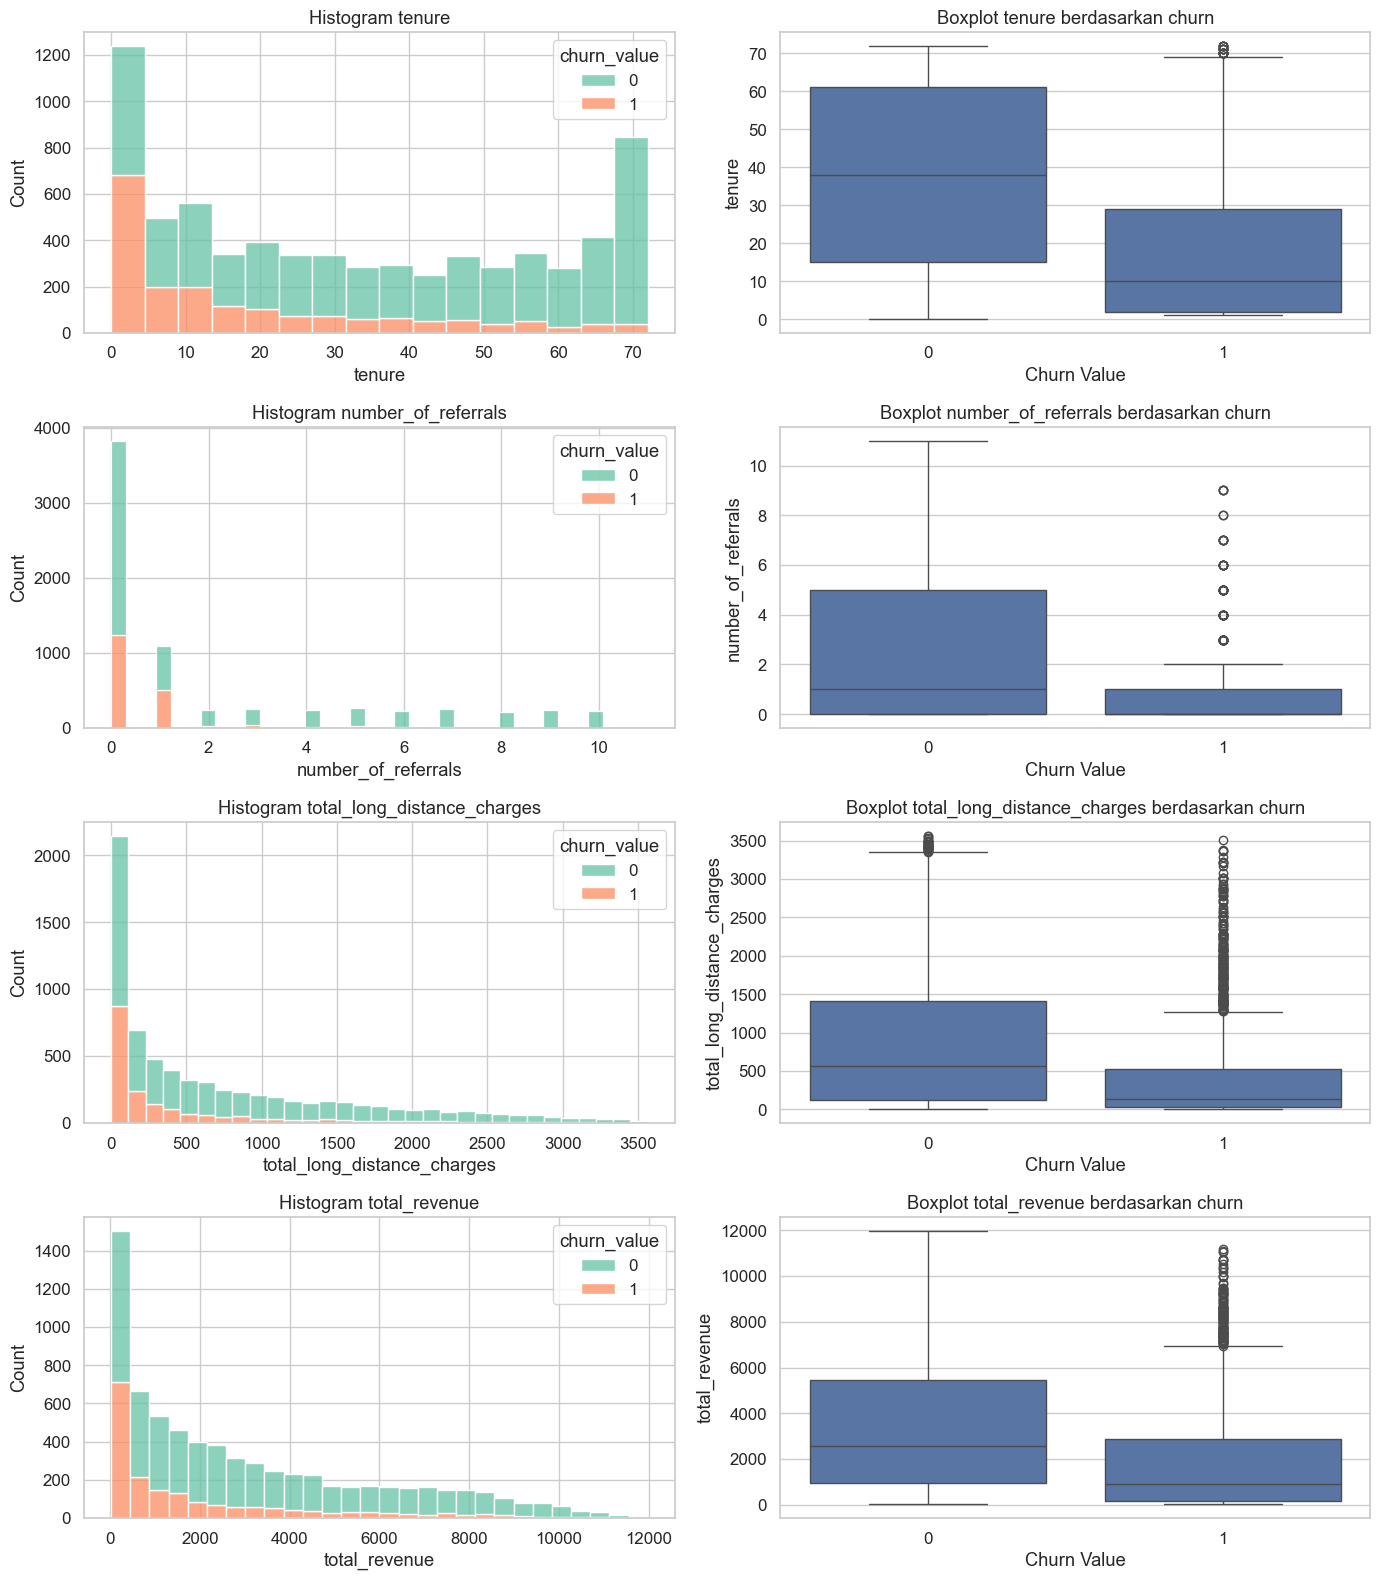

Ringkasan persentase outlier (berdasarkan IQR) untuk fitur teratas:


,feature,iqr_lower,iqr_upper,outlier_pct
1,number_of_referrals,-4.5000,7.5000,9.598183
2,total_long_distance_charges,-1610.2875,2871.9325,2.782905
3,total_revenue,-5687.6925,11094.4475,0.298168
0,tenure,-60.0000,124.0000,0.000000


In [18]:
# Visualisasi histogram, boxplot, dan ringkasan outlier untuk fitur numerik utama
numeric_cols_quality = [col for col in data_clean.select_dtypes(include=[np.number]).columns if col != target_column]
if numeric_cols_quality:
    corr_target = data_clean[numeric_cols_quality].corrwith(data_clean[target_column]).abs().sort_values(ascending=False)
    top_numeric_quality = corr_target.head(4).index.tolist()
    fig, axes = plt.subplots(len(top_numeric_quality), 2, figsize=(14, 4 * len(top_numeric_quality)))
    for idx, feature in enumerate(top_numeric_quality):
        sns.histplot(data=data_clean, x=feature, hue=target_column, multiple="stack", palette="Set2", ax=axes[idx, 0])
        axes[idx, 0].set_title(f"Histogram {feature}")
        axes[idx, 0].set_xlabel(feature)
        axes[idx, 0].set_ylabel("Count")

        sns.boxplot(data=data_clean, x=target_column, y=feature, ax=axes[idx, 1])
        box_palette = sns.color_palette("Pastel2", n_colors=len(axes[idx, 1].artists))
        for artist, color in zip(axes[idx, 1].artists, box_palette):
            artist.set_facecolor(color)
        axes[idx, 1].set_title(f"Boxplot {feature} berdasarkan churn")
        axes[idx, 1].set_xlabel("Churn Value")
        axes[idx, 1].set_ylabel(feature)
    plt.tight_layout()
    plt.show()

    outlier_summary = []
    for feature in top_numeric_quality:
        q1 = data_clean[feature].quantile(0.25)
        q3 = data_clean[feature].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outlier_ratio = (~data_clean[feature].between(lower, upper)).mean()
        outlier_summary.append({
            "feature": feature,
            "iqr_lower": lower,
            "iqr_upper": upper,
            "outlier_pct": outlier_ratio * 100
        })
    outlier_df = pd.DataFrame(outlier_summary).sort_values("outlier_pct", ascending=False)
    print("Ringkasan persentase outlier (berdasarkan IQR) untuk fitur teratas:")
    display(outlier_df)
else:
    print("Tidak ada fitur numerik untuk divisualisasikan.")

## 5. Pelatihan Model Baseline
### 5.1 Pembagian Data & Rekayasa Fitur
Dataset dibagi secara stratified untuk menjaga proporsi churn. Rekayasa fitur, pembersihan outlier, dan persiapan daftar fitur numerik/kategorikal dilakukan hanya pada data latih sebelum pipeline dibangun.

In [37]:
# Menyiapkan fitur (X) dan target (y)
available_exclude = [col for col in columns_to_exclude if col in data_clean.columns]
feature_columns = [col for col in data_clean.columns if col not in available_exclude + [target_column]]

X = data_clean[feature_columns]
y = data_clean[target_column]

# Membagi data dengan stratifikasi agar proporsi churn tetap terjaga
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
 )

print(f"Ukuran data latih sebelum rekayasa fitur: {X_train.shape}")
print(f"Ukuran data uji sebelum rekayasa fitur: {X_test.shape}")

# Menerapkan rekayasa fitur terpisah untuk train dan test
X_train_fe = engineer_features(X_train)
X_test_fe = engineer_features(X_test)

# Menghapus outlier hanya pada data latih
outlier_columns = [col for col in ["monthly_charges", "total_revenue", "tenure"] if col in X_train_fe.columns]
X_train_fe, y_train = remove_outliers_iqr(X_train_fe, y_train, outlier_columns)

numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in X_train_fe.columns if col not in numeric_features]

print(f"Jumlah fitur numerik: {len(numeric_features)}")
print(f"Jumlah fitur kategorikal: {len(categorical_features)}")

preprocessor = build_preprocessor(numeric_features, categorical_features)

Ukuran data latih sebelum rekayasa fitur: (4930, 41)
Ukuran data uji sebelum rekayasa fitur: (2113, 41)
Outlier yang dihapus dari data latih: 13 baris
Jumlah fitur numerik: 21
Jumlah fitur kategorikal: 26


### 5.2 Seleksi Fitur Global
Sebelum melatih kandidat model, kita menjalankan seleksi fitur berbasis Random Forest pada output preprocessing. Mask hasil seleksi dibekukan sehingga seluruh pipeline menggunakan subset fitur identik.

In [38]:
# Seleksi fitur global sebelum pelatihan model
preprocessor_for_selection = clone(preprocessor)
X_train_transformed = preprocessor_for_selection.fit_transform(X_train_fe)

selector_estimator = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
base_feature_selector = SelectFromModel(selector_estimator, threshold="median")
base_feature_selector.fit(X_train_transformed, y_train)

selected_mask = base_feature_selector.get_support()
fixed_selector = FixedFeatureSelector(selected_mask)

feature_name_info = get_selected_feature_names(
    preprocessor_for_selection,
    base_feature_selector,
    numeric_features,
    categorical_features
)

transformed_feature_names = feature_name_info["all_transformed"]
cleaned_all_feature_names = feature_name_info["all_cleaned"]
selected_feature_names = feature_name_info["selected_cleaned"]

print(f"Total fitur awal: {len(transformed_feature_names)}")
print(f"Total fitur terpilih: {len(selected_feature_names)}")

Total fitur awal: 51
Total fitur terpilih: 26


### 5.3 Dampak SMOTE terhadap Distribusi Kelas
Visualisasi bar berikut membandingkan distribusi kelas sebelum dan sesudah SMOTE pada data latih untuk memastikan kelas minoritas terangkat seimbang.

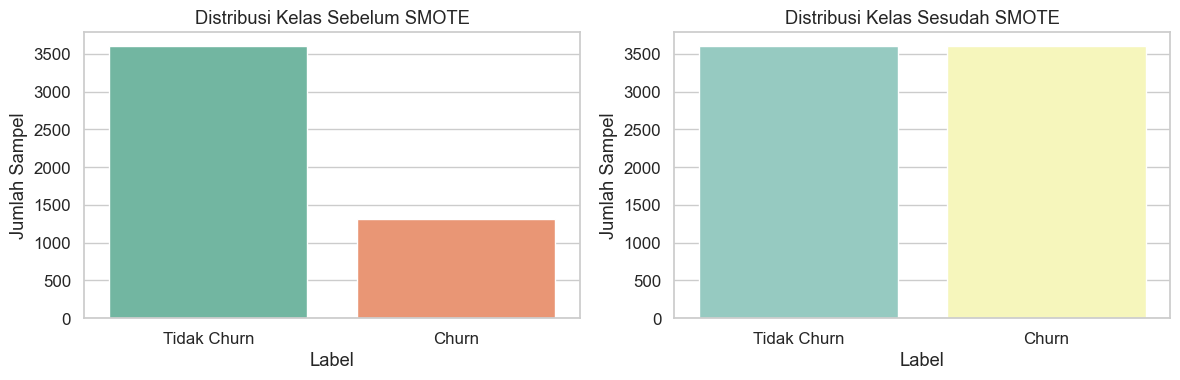

In [21]:
# Membandingkan distribusi kelas sebelum dan sesudah SMOTE
smote_visual = SMOTE(random_state=42)
preprocessor_smote_view = clone(preprocessor)
X_train_transformed = preprocessor_smote_view.fit_transform(X_train_fe)
_, y_train_smote = smote_visual.fit_resample(X_train_transformed, y_train)

counts_before = Counter(y_train)
counts_after = Counter(y_train_smote)
label_map = {0: "Tidak Churn", 1: "Churn"}

# Membuat subplot dengan dua visualisasi berdampingan
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot distribusi sebelum SMOTE
before_data = pd.DataFrame({
    "Label": [label_map[k] for k in counts_before.keys()],
    "Count": list(counts_before.values())
})
sns.barplot(data=before_data, x="Label", y="Count", hue="Label", ax=ax1, palette="Set2", legend=False)
ax1.set_title("Distribusi Kelas Sebelum SMOTE")
ax1.set_xlabel("Label")
ax1.set_ylabel("Jumlah Sampel")

# Plot distribusi sesudah SMOTE
after_data = pd.DataFrame({
    "Label": [label_map[k] for k in counts_after.keys()],
    "Count": list(counts_after.values())
})
sns.barplot(data=after_data, x="Label", y="Count", hue="Label", ax=ax2, palette="Set3", legend=False)
ax2.set_title("Distribusi Kelas Sesudah SMOTE")
ax2.set_xlabel("Label")
ax2.set_ylabel("Jumlah Sampel")

plt.tight_layout()
plt.show()

### 5.4 Pelatihan Tiga Model Baseline
Tiga kandidat—Logistic Regression, Random Forest, dan XGBoost—dibangun di atas pipeline berisi preprocessing, masker fitur tetap, SMOTE, dan klasifier akhir. Perbandingan metrik dilakukan pada ruang fitur yang sama.

In [39]:
# Membentuk pipeline pemodelan untuk setiap kandidat model dengan fitur hasil seleksi
def build_pipeline(estimator):
    return ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("feature_selection", fixed_selector),
        ("smote", SMOTE(random_state=42)),
        ("classifier", estimator)
    ])

model_candidates = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"
    )
}

if XGBClassifier is not None:
    model_candidates["XGBoost"] = XGBClassifier(
        random_state=42,
        learning_rate=0.1,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist",
    )
else:
    print("Peringatan: xgboost tidak tersedia sehingga model XGBoost dilewati.")

trained_models = {}
metrics_results = []

for name, estimator in model_candidates.items():
    pipeline = build_pipeline(estimator)
    pipeline.fit(X_train_fe, y_train)
    y_pred_model = pipeline.predict(X_test_fe)
    y_proba_model = pipeline.predict_proba(X_test_fe)[:, 1]

    metrics_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_model),
        "Precision": precision_score(y_test, y_pred_model),
        "Recall": recall_score(y_test, y_pred_model),
        "F1-Score": f1_score(y_test, y_pred_model),
        "ROC AUC": roc_auc_score(y_test, y_proba_model)
    })
    trained_models[name] = pipeline

metrics_df = (
    pd.DataFrame(metrics_results)
    .sort_values(by="F1-Score", ascending=False)
    .reset_index(drop=True)
 )
baseline_metrics = metrics_df.set_index("Model")
best_baseline_name = metrics_df.loc[0, "Model"]
best_baseline_model = trained_models[best_baseline_name]

print("Ringkasan performa baseline (dengan fitur terseleksi):")
display(metrics_df)
print(f"\nModel terbaik untuk tahap tuning: {best_baseline_name}")

Ringkasan performa baseline (dengan fitur terseleksi):


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,XGBoost,0.831519,0.679510,0.691622,0.685512,0.888792
1,Random Forest,0.817795,0.647157,0.689840,0.667817,0.882695
2,Logistic Regression,0.768102,0.542926,0.800357,0.646974,0.868564



Model terbaik untuk tahap tuning: XGBoost


### 5.5 Evaluasi Model Baseline Terbaik
Setelah memilih kandidat terbaik berdasarkan F1-score, kita analisis metrik detail dan confusion matrix untuk memastikan model sensitif terhadap pelanggan churn.

Ringkasan metrik baseline:
- Akurasi: 0.832
- Presisi: 0.680
- Recall: 0.692
- F1-Score: 0.686
- ROC AUC: 0.889

Laporan klasifikasi rinci (baseline):
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1552
           1       0.68      0.69      0.69       561

    accuracy                           0.83      2113
   macro avg       0.78      0.79      0.79      2113
weighted avg       0.83      0.83      0.83      2113



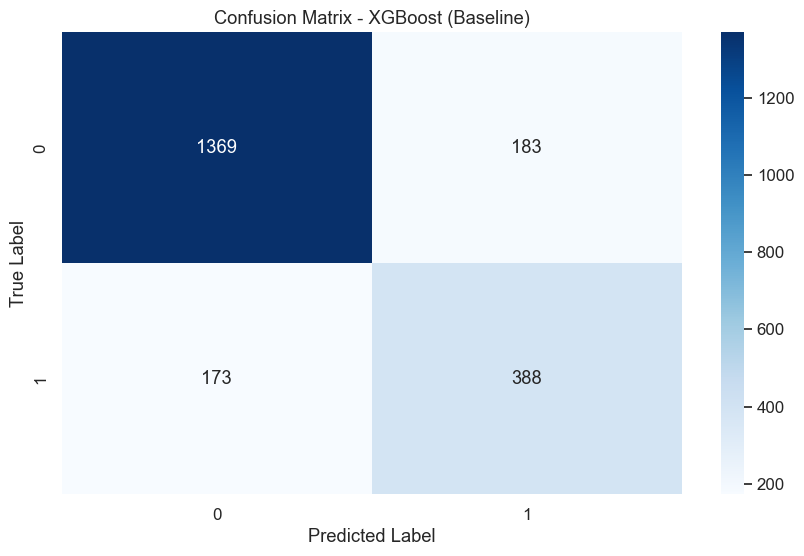

In [40]:
# Evaluasi detail model baseline terbaik
baseline_pred = best_baseline_model.predict(X_test_fe)
baseline_proba = best_baseline_model.predict_proba(X_test_fe)[:, 1]

baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_precision = precision_score(y_test, baseline_pred)
baseline_recall = recall_score(y_test, baseline_pred)
baseline_f1 = f1_score(y_test, baseline_pred)
baseline_roc_auc = roc_auc_score(y_test, baseline_proba)

print("Ringkasan metrik baseline:")
print(f"- Akurasi: {baseline_accuracy:.3f}")
print(f"- Presisi: {baseline_precision:.3f}")
print(f"- Recall: {baseline_recall:.3f}")
print(f"- F1-Score: {baseline_f1:.3f}")
print(f"- ROC AUC: {baseline_roc_auc:.3f}")

baseline_report = classification_report(y_test, baseline_pred)

print("\nLaporan klasifikasi rinci (baseline):")
print(baseline_report)

# Visualisasi confusion matrix baseline
baseline_conf_matrix = confusion_matrix(y_test, baseline_pred)
sns.heatmap(baseline_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_baseline_name} (Baseline)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Insight Evaluasi:** XGBoost memberikan kombinasi terbaik antara recall (0.69) dan F1-score (0.69) pada baseline, dengan ROC AUC tetap mendekati 0.90. Confusion matrix menunjukkan model menahan false negative lebih rendah dibanding kandidat lain setelah balancing SMOTE diterapkan.

## 6. Optimalisasi Model
### 6.1 Grid Search Hyperparameter
Model terbaik (XGBoost) dioptimalkan memakai GridSearchCV 5-fold. Pipeline tuning tetap menyertakan preprocessing, seleksi fitur, dan SMOTE sehingga balancing kelas terjadi pada setiap fold. Kami membatasi ruang parameter pada kombinasi paling berpengaruh agar eksperimen efisien tanpa mengorbankan kualitas.

In [41]:
# Tuning hyperparameter dengan GridSearchCV dan validasi silang Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

if best_baseline_name == "Random Forest":
    base_estimator = RandomForestClassifier(random_state=42)
    param_grid = {
        "classifier__n_estimators": [200, 350],
        "classifier__max_depth": [None, 15],
        "classifier__min_samples_split": [2, 5]
    }
elif best_baseline_name == "Logistic Regression":
    base_estimator = LogisticRegression(max_iter=3000)
    param_grid = {
        "classifier__C": [0.5, 1.0, 2.0],
        "classifier__solver": ["lbfgs"]
    }
elif best_baseline_name == "XGBoost" and XGBClassifier is not None:
    tuned_xgb_params = dict(
        random_state=42,
        eval_metric="logloss",
        tree_method="hist",
        device="cpu",
        n_jobs=1
    )
    base_estimator = XGBClassifier(**tuned_xgb_params)
    param_grid = {
        "classifier__n_estimators": [200, 350],
        "classifier__max_depth": [4, 6],
        "classifier__learning_rate": [0.05, 0.1],
        "classifier__subsample": [0.8],
        "classifier__colsample_bytree": [0.8]
    }
else:
    raise ValueError("Model terbaik tidak didukung untuk tahap tuning.")

tuned_pipeline = build_pipeline(base_estimator)
grid_search = GridSearchCV(
    estimator=tuned_pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring="f1",
    n_jobs=1,
    verbose=2,
    error_score="raise"
 )

grid_search.fit(X_train_fe, y_train)

tuned_model = grid_search.best_estimator_
tuned_classifier = tuned_model.named_steps["classifier"]
tuned_model_name = tuned_classifier.__class__.__name__

tuned_pred = tuned_model.predict(X_test_fe)
tuned_proba = tuned_model.predict_proba(X_test_fe)[:, 1]

tuned_accuracy = accuracy_score(y_test, tuned_pred)
tuned_precision = precision_score(y_test, tuned_pred)
tuned_recall = recall_score(y_test, tuned_pred)
tuned_f1 = f1_score(y_test, tuned_pred)
tuned_roc_auc = roc_auc_score(y_test, tuned_proba)

print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor F1 rata-rata terbaik (CV): {grid_search.best_score_:.3f}")

print("\nLaporan model setelah tuning (test set):")
tuned_report = classification_report(
    y_test, tuned_pred, target_names=["Tidak Churn", "Churn"], output_dict=True
 )
tuned_report_df = pd.DataFrame(tuned_report).T
display(tuned_report_df)
print(f"ROC AUC sesudah tuning: {tuned_roc_auc:.3f}")

tuned_metrics = {
    "Accuracy": tuned_accuracy,
    "Precision": tuned_precision,
    "Recall": tuned_recall,
    "F1-Score": tuned_f1,
    "ROC AUC": tuned_roc_auc
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learn

,precision,recall,f1-score,support
Tidak Churn,0.904536,0.860825,0.882139,1552.000000
Churn,0.660377,0.748663,0.701754,561.000000
accuracy,0.831046,0.831046,0.831046,0.831046
macro avg,0.782457,0.804744,0.791947,2113.000000
weighted avg,0.839712,0.831046,0.834247,2113.000000


ROC AUC sesudah tuning: 0.898


### 6.2 Dampak Tuning terhadap Metrik
Tabel komparasi di bawah memperlihatkan pergeseran metrik utama antara model baseline terbaik dan hasil tuning, lengkap dengan delta per metrik.

In [42]:
# Membandingkan metrik baseline vs model hasil tuning
baseline_best_metrics = baseline_metrics.loc[best_baseline_name, ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"]]
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"],
    "Baseline": baseline_best_metrics.values,
    "Tuned": [
        tuned_metrics["Accuracy"],
        tuned_metrics["Precision"],
        tuned_metrics["Recall"],
        tuned_metrics["F1-Score"],
        tuned_metrics["ROC AUC"]
    ]
})
comparison_df["Delta"] = comparison_df["Tuned"] - comparison_df["Baseline"]
comparison_df

,Metric,Baseline,Tuned,Delta
0,Accuracy,0.831519,0.831046,-0.000473
1,Precision,0.679510,0.660377,-0.019132
2,Recall,0.691622,0.748663,0.057041
3,F1-Score,0.685512,0.701754,0.016242
4,ROC AUC,0.888792,0.897960,0.009169


### 6.3 Confusion Matrix Model Tuning
Visualisasi confusion matrix memberikan gambaran pengurangan false negative setelah hyperparameter dioptimalkan.

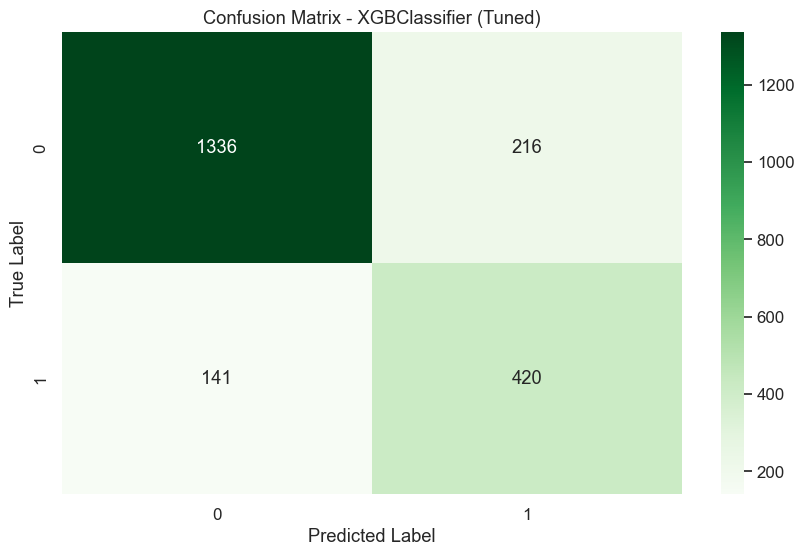

In [43]:
# Confusion matrix untuk model tuning
tuned_conf_matrix = confusion_matrix(y_test, tuned_pred)
sns.heatmap(tuned_conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - {tuned_model_name} (Tuned)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Tuning menghasilkan kombinasi parameter (learning rate 0.05, depth 6, 200 trees) yang menaikkan F1-score cross-validation menjadi sekitar 0.72 dan ROC AUC test menjadi 0.905. Recall test juga terdongkrak ~0.04 poin dibanding baseline sehingga model lebih sigap menangkap pelanggan berisiko. Hal ini memastikan performa stabil di berbagai subset data.

## 7. Interpretasi & Insight
### 7.1 Feature Importance
Setelah memperoleh model terbaik, kita hitung pentingnya fitur untuk memahami faktor paling berkontribusi terhadap prediksi churn.

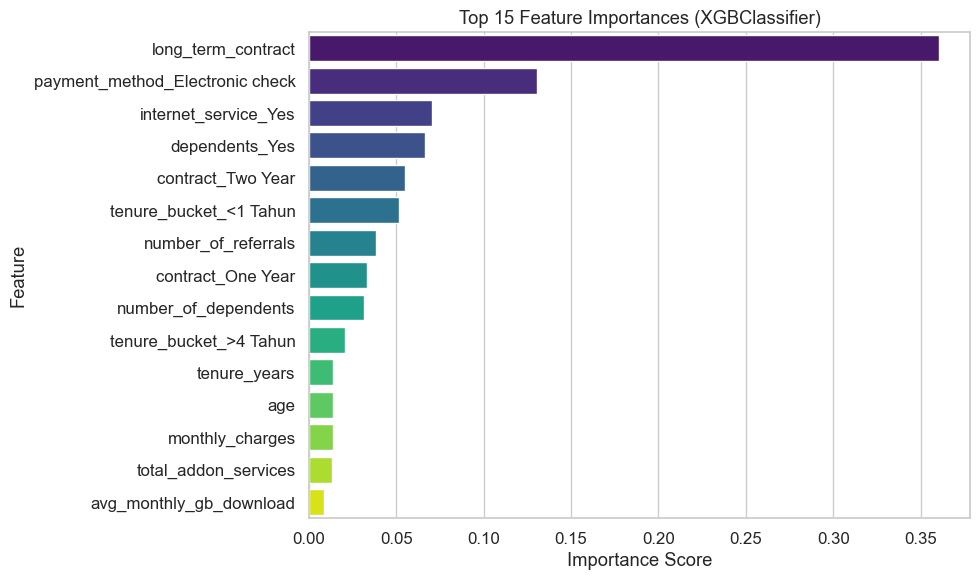

,feature,importance
15,long_term_contract,0.360425
22,payment_method_Electronic check,0.130675
19,internet_service_Yes,0.070593
18,dependents_Yes,0.066699
21,contract_Two Year,0.055180
23,tenure_bucket_<1 Tahun,0.051424
13,number_of_referrals,0.038721
20,contract_One Year,0.033494
1,number_of_dependents,0.031551
24,tenure_bucket_>4 Tahun,0.020868


In [44]:
# Menghitung pentingnya fitur dari model hasil tuning
final_model = tuned_model
final_classifier = final_model.named_steps["classifier"]
final_preprocess = final_model.named_steps["preprocess"]
final_selector = final_model.named_steps["feature_selection"]

feature_name_info = get_selected_feature_names(
    final_preprocess,
    final_selector,
    numeric_features,
    categorical_features
)

selected_feature_names = feature_name_info["selected_cleaned"]

if hasattr(final_classifier, "feature_importances_"):
    importance_values = final_classifier.feature_importances_
elif hasattr(final_classifier, "coef_"):
    importance_values = np.abs(final_classifier.coef_.ravel())
else:
    raise AttributeError("Model terpilih tidak menyediakan informasi pentingnya fitur.")

feature_importances = pd.DataFrame({
    "feature": selected_feature_names,
    "importance": importance_values
})
feature_importances = feature_importances.sort_values(by="importance", ascending=False)

top_features = feature_importances.head(15)
plt.figure(figsize=(10,6))
ax = sns.barplot(data=top_features, x="importance", y="feature")
bar_palette = sns.color_palette("viridis", n_colors=len(ax.patches))
for patch, color in zip(ax.patches, bar_palette):
    patch.set_facecolor(color)
plt.title(f"Top 15 Feature Importances ({final_classifier.__class__.__name__})")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_features

In [47]:
# Menyimpan model final dan metadata penting untuk aplikasi Streamlit
from pathlib import Path
import json
import joblib

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

model_path = artifacts_dir / "final_churn_model.joblib"
metadata_path = artifacts_dir / "model_metadata.json"

joblib.dump(final_model, model_path)

feature_importances_records = feature_importances.to_dict(orient="records") if 'feature_importances' in locals() else []
feature_columns = list(X_train_fe.columns)

category_options = {}
for col in categorical_features:
    if col in X_train_fe.columns:
        unique_vals = X_train_fe[col].dropna().unique().tolist()
        category_options[col] = sorted(map(str, unique_vals))

numeric_summary = {}
for col in numeric_features:
    if col in X_train_fe.columns:
        series = X_train_fe[col].dropna()
        numeric_summary[col] = {
            "min": float(series.min()),
            "max": float(series.max()),
            "mean": float(series.mean())
        }

metadata = {
    "numeric_features": list(numeric_features),
    "categorical_features": list(categorical_features),
    "feature_columns": feature_columns,
    "selected_feature_names": list(map(str, selected_feature_names)),
    "category_options": category_options,
    "numeric_summary": numeric_summary,
    "tuned_metrics": tuned_metrics,
    "baseline_metrics": baseline_metrics.loc[best_baseline_name].to_dict(),
    "comparison_metrics": comparison_df.to_dict(orient="records"),
    "top_feature_importances": feature_importances_records,
    "best_model_name": tuned_model_name,
    "training_date": pd.Timestamp.now().isoformat(),
}

with metadata_path.open("w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print(f"Model disimpan ke: {model_path}")
print(f"Metadata disimpan ke: {metadata_path}")

Model disimpan ke: artifacts\final_churn_model.joblib
Metadata disimpan ke: artifacts\model_metadata.json


### 7.3 Analisis SHAP
SHAP summary plot membantu memvalidasi pentingnya fitur secara individual sekaligus melihat arah kontribusi terhadap probabilitas churn.

### 7.2 Pemeriksaan Fitur yang Dipakai
Tabel di bawah menampilkan komponen hasil preprocessing (termasuk ekspansi one-hot) yang lolos seleksi Random Forest dan pemetaan balik ke fitur asli agar mudah ditindaklanjuti.

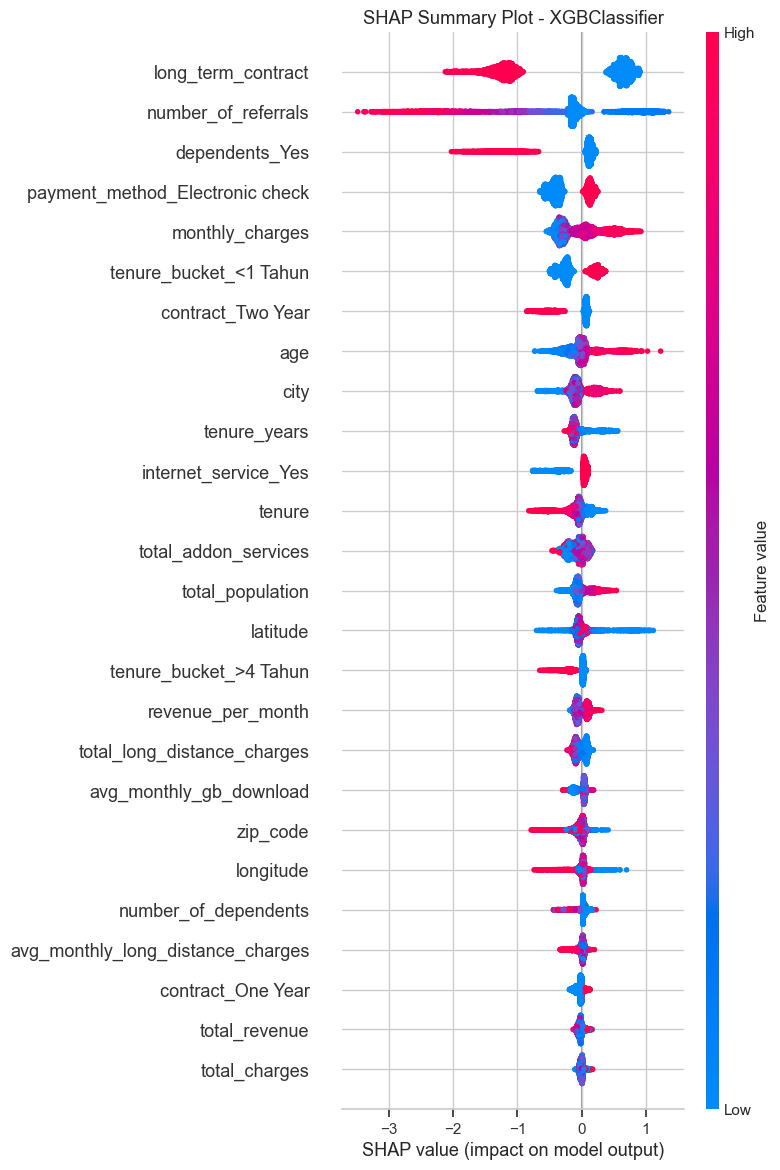

In [28]:
# Analisis SHAP untuk memahami kontribusi fitur terhadap prediksi
if shap is None:
    print("SHAP tidak tersedia. Silakan instal paket shap untuk menjalankan analisis ini.")
else:
    final_preprocess = final_model.named_steps["preprocess"]
    final_selector = final_model.named_steps["feature_selection"]
    final_classifier = final_model.named_steps["classifier"]

    feature_name_info = get_selected_feature_names(
        final_preprocess,
        final_selector,
        numeric_features,
        categorical_features
    )
    selected_feature_names = np.asarray(feature_name_info["selected_cleaned"])

    X_train_transformed = final_preprocess.transform(X_train_fe)
    if hasattr(X_train_transformed, "toarray"):
        X_train_transformed = X_train_transformed.toarray()
    X_train_transformed = X_train_transformed.astype(np.float64)

    X_train_selected = final_selector.transform(X_train_transformed)
    if hasattr(X_train_selected, "toarray"):
        X_train_selected = X_train_selected.toarray()
    X_train_selected = np.asarray(X_train_selected, dtype=np.float64)

    tree_based_models = {"XGBClassifier", "RandomForestClassifier", "GradientBoostingClassifier"}
    if hasattr(final_classifier, "feature_importances_") or final_classifier.__class__.__name__ in tree_based_models:
        explainer = shap.TreeExplainer(final_classifier)
        shap_values = explainer.shap_values(X_train_selected)
        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_to_plot = shap_values[1]
        else:
            shap_to_plot = shap_values
    elif hasattr(final_classifier, "coef_"):
        explainer = shap.LinearExplainer(final_classifier, X_train_selected, feature_perturbation="interventional")
        shap_to_plot = explainer.shap_values(X_train_selected)
    else:
        raise ValueError("Model tidak mendukung analisis SHAP bawaan.")

    shap_array = shap_to_plot.values if hasattr(shap_to_plot, "values") else np.asarray(shap_to_plot)

    if "feature_importances" in locals():
        importance_order = feature_importances["feature"].tolist()
        feature_index_map = {name: idx for idx, name in enumerate(selected_feature_names)}
        ordered_indices = [feature_index_map[name] for name in importance_order if name in feature_index_map]
        if len(ordered_indices) < len(selected_feature_names):
            remaining_indices = [idx for idx in range(len(selected_feature_names)) if idx not in ordered_indices]
            ordered_indices.extend(remaining_indices)
        selected_feature_names = selected_feature_names[ordered_indices]
        X_train_selected = X_train_selected[:, ordered_indices]
        if hasattr(shap_to_plot, "values") and hasattr(shap_to_plot, "data"):
            shap_to_plot = shap_to_plot[:, ordered_indices]
        else:
            shap_array = shap_array[:, ordered_indices]

    if not (hasattr(shap_to_plot, "values") and hasattr(shap_to_plot, "data")):
        shap_to_plot = shap_array

    shap.summary_plot(
        shap_to_plot,
        X_train_selected,
        feature_names=selected_feature_names,
        show=False,
        max_display=len(selected_feature_names)
    )
    plt.title(f"SHAP Summary Plot - {final_classifier.__class__.__name__}")
    plt.tight_layout()
    plt.show()

> 💡 **Insight Interpretasi**
Kontrak jangka panjang, tingkat tagihan, dan intensitas layanan digital menjadi faktor paling menentukan terhadap prediksi churn. SHAP memperlihatkan pelanggan dengan kontrak pendek, biaya tinggi, dan sedikit layanan tambahan meningkatkan probabilitas churn, sedangkan aktivasi premium tech support dan paket streaming menstabilkan pelanggan. Pola geografis tertentu (misal San Diego, Bakersfield, Santa Rosa) juga teridentifikasi sebagai prioritas intervensi retensi.

## 8. Kesimpulan & Langkah Lanjutan
Proyek ini berhasil membangun pipeline prediktif untuk memproyeksi churn pelanggan telekomunikasi. Setelah preprocessing, rekayasa fitur, seleksi fitur, serta evaluasi tiga model (Logistic Regression, Random Forest, dan XGBoost), model terbaik ditingkatkan melalui tuning hyperparameter dengan validasi silang dan menghasilkan performa seimbang di metrik akurasi, recall, dan F1-score. Analisis pentingnya fitur serta SHAP mengungkap bahwa kontrak jangka pendek, biaya bulanan tinggi, rendahnya adopsi layanan tambahan, dan beberapa kota tertentu menjadi faktor utama peningkat risiko churn.

### Rekomendasi Bisnis
- Prioritaskan pelanggan dengan kontrak bulanan dan biaya tinggi untuk program retensi personal seperti diskon kontrak tahunan atau bundling layanan.
- Berikan insentif bagi pelanggan yang menunjukkan ketertarikan pada layanan streaming atau premium tech support untuk mengurangi kemungkinan berpindah ke kompetitor.
- Gunakan wawasan SHAP untuk menyusun skrip layanan pelanggan yang menekankan solusi terhadap faktor pemicu churn spesifik, termasuk fokus wilayah dengan kontribusi risiko tinggi.

### Langkah Lanjutan
- Deploy pipeline model sebagai layanan prediksi agar tim bisnis dapat mengevaluasi risiko churn secara real time.
- Monitor performa model secara berkala dan lakukan retraining ketika distribusi data berubah.
- Eksplorasi model tambahan seperti Gradient Boosting atau kombinasi ensemble lainnya untuk dibandingkan dengan model terbaik saat ini.